In [1]:
import pandas as pd
import pm4py

### Importing the log

In [2]:
file_path = "./running-example.csv"
event_log = pm4py.format_dataframe(pd.read_csv(file_path, sep=';'), case_id='case_id', activity_key='activity', timestamp_key='timestamp', timest_format='%Y-%m-%d %H:%M:%S%z')

event_log

,case_id,activity,timestamp,costs,resource,case:concept:name,concept:name,time:timestamp,@@index
14,1,register request,2010-12-30 10:02:00+00:00,50,Pete,1,register request,2010-12-30 10:02:00+00:00,14
15,1,examine thoroughly,2010-12-31 09:06:00+00:00,400,Sue,1,examine thoroughly,2010-12-31 09:06:00+00:00,15
16,1,check ticket,2011-01-05 14:12:00+00:00,100,Mike,1,check ticket,2011-01-05 14:12:00+00:00,16
17,1,decide,2011-01-06 10:18:00+00:00,200,Sara,1,decide,2011-01-06 10:18:00+00:00,17
18,1,reject request,2011-01-07 13:24:00+00:00,200,Pete,1,reject request,2011-01-07 13:24:00+00:00,18
9,2,register request,2010-12-30 10:32:00+00:00,50,Mike,2,register request,2010-12-30 10:32:00+00:00,9
10,2,check ticket,2010-12-30 11:12:00+00:00,100,Mike,2,check ticket,2010-12-30 11:12:00+00:00,10
11,2,examine casually,2010-12-30 13:16:00+00:00,400,Sean,2,examine casually,2010-12-30 13:16:00+00:00,11
12,2,decide,2011-01-05 10:22:00+00:00,200,Sara,2,decide,2011-01-05 10:22:00+00:00,12
13,2,pay compensation,2011-01-08 11:05:00+00:00,200,Ellen,2,pay compensation,2011-01-08 11:05:00+00:00,13


In [3]:
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'register request': 6}
End activities: {'reject request': 3, 'pay compensation': 3}


### Process Discovery
Petri Net (using two different algorithms)

c:\users\savoi\pycharmprojects\pm4py-test\venv\lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:82: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_reduced = df[{case_id_glue, activity_key, target_activity_key}]


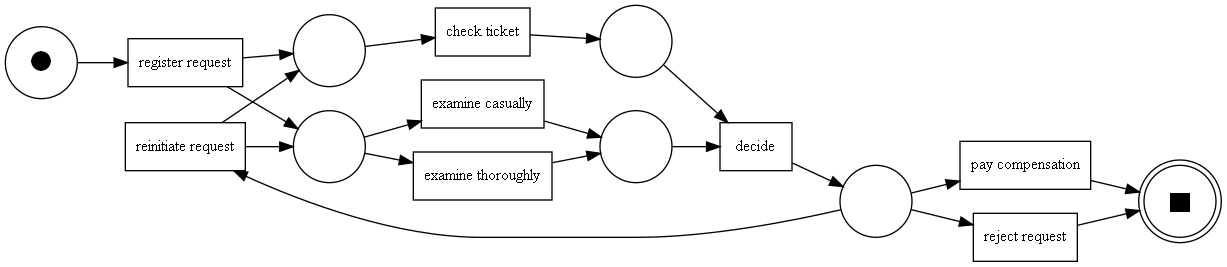

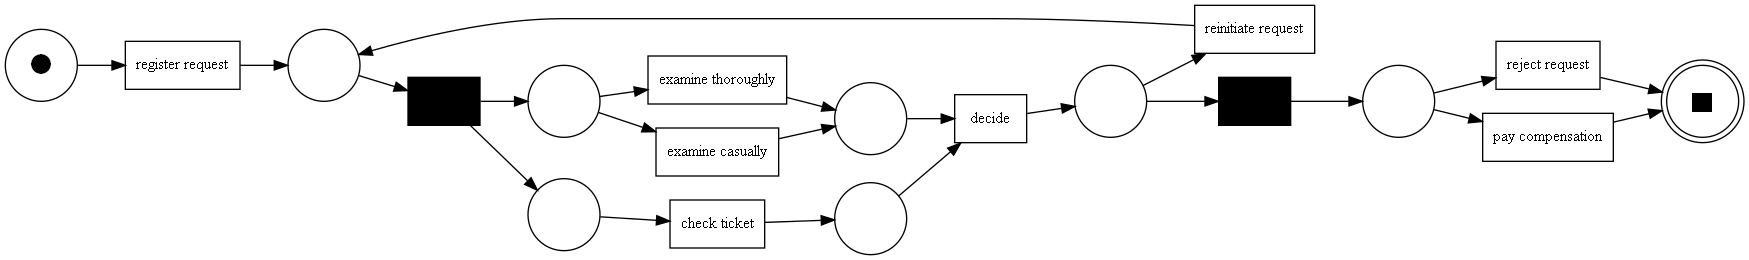

In [4]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# Alpha Miner
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
alpha_net, alpha_initial_marking, alpha_final_marking = alpha_miner.apply(event_log)
alpha_graphviz = pn_visualizer.apply(alpha_net, alpha_initial_marking, alpha_final_marking)
alpha_graphviz.graph_attr['bgcolor'] = 'white'
pn_visualizer.view(alpha_graphviz)
pn_visualizer.save(alpha_graphviz, "pn_alpha_miner.png")

# Inductive Miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
ind_net, ind_initial_marking, ind_final_marking = inductive_miner.apply(event_log)
ind_graphviz = pn_visualizer.apply(ind_net, ind_initial_marking, ind_final_marking)
ind_graphviz.graph_attr['bgcolor'] = 'white'
pn_visualizer.view(ind_graphviz)
pn_visualizer.save(ind_graphviz, "pn_inductive_miner.png")

Other possible process models

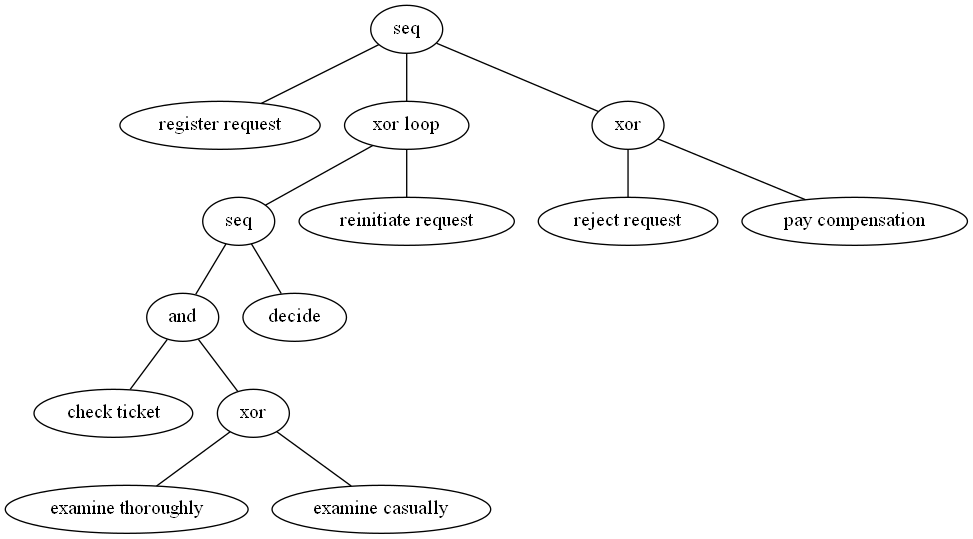

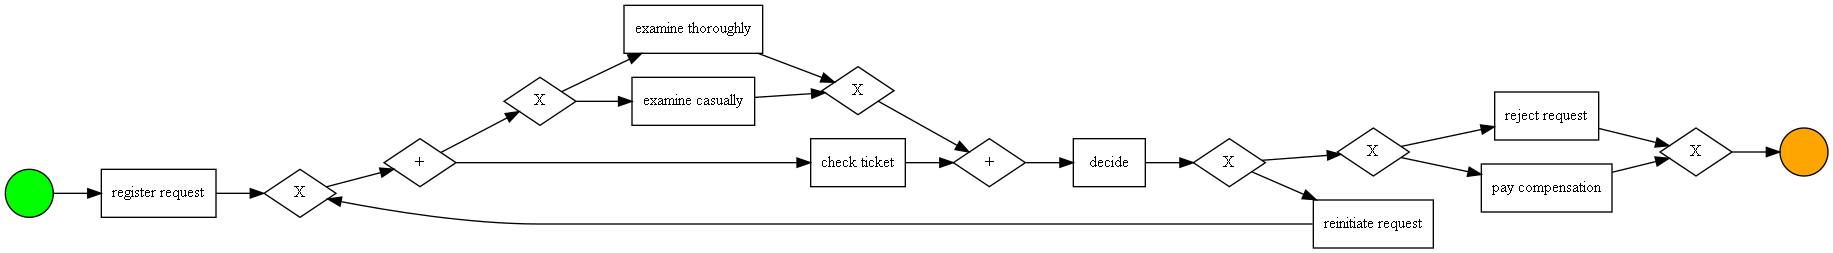

c:\users\savoi\pycharmprojects\pm4py-test\venv\lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:82: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_reduced = df[{case_id_glue, activity_key, target_activity_key}]


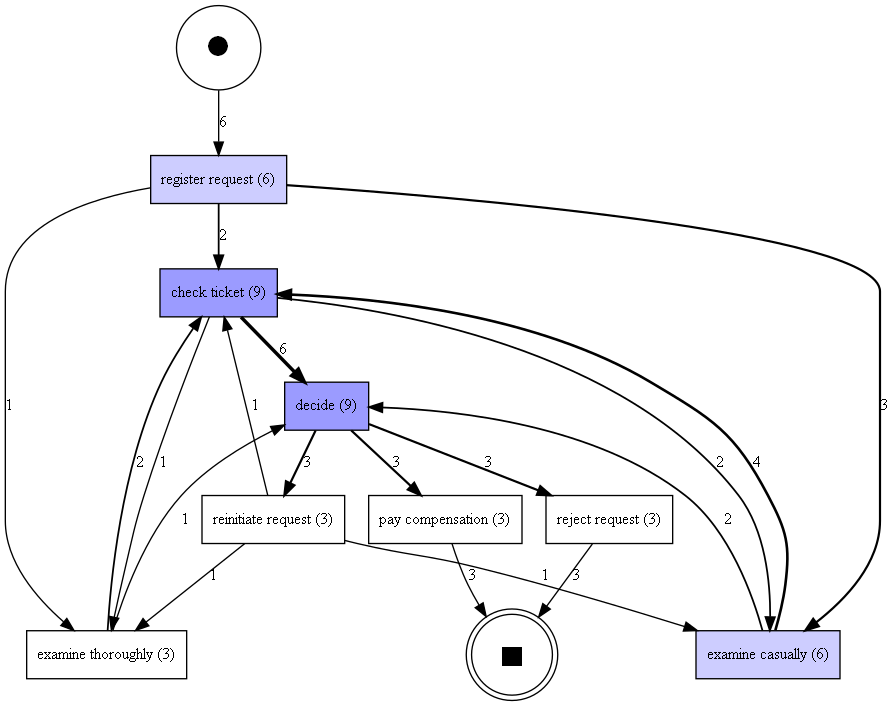

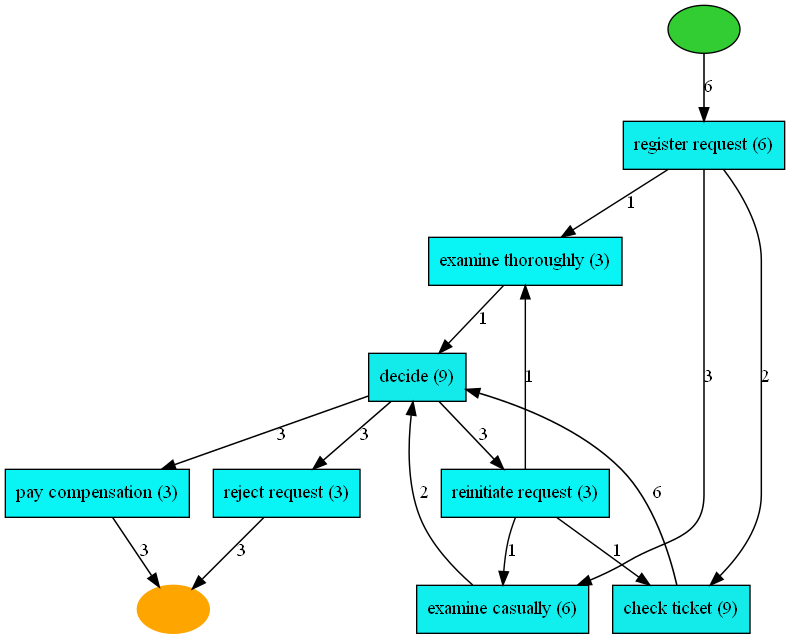

In [5]:
# Process Tree
process_tree = pm4py.discover_process_tree_inductive(event_log)
pm4py.view_process_tree(process_tree)

# BPMN Model
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model)

# Process Map (Directly Follows Graph)
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

# Heuristic Miner
heu = pm4py.discover_heuristics_net(event_log)
pm4py.view_heuristics_net(heu)

### Conformance Checking